## Imports

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ivan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## Dataset

In [100]:
df = pd.read_csv("../data/unemployment_tweets.csv")
df.head()

,tweet
0,"#Unemployment below 700,000, lowest since Apri..."
1,Throwback to this opinion piece I wrote on Jun...
2,Malaysia Witnesses Influx Of Indonesian Migran...
3,Unemployment levels over 30 years in Malaysia ...
4,Happy to see unemployment levels dipping in Ma...


In [101]:
def analyze_text(text):
    score = SentimentIntensityAnalyzer().polarity_scores(text)
    return score["compound"]

In [102]:
df["compound score"] = df["tweet"].apply(analyze_text)
df.head()

,tweet,compound score
0,"#Unemployment below 700,000, lowest since Apri...",-0.3818
1,Throwback to this opinion piece I wrote on Jun...,0.1779
2,Malaysia Witnesses Influx Of Indonesian Migran...,0.0000
3,Unemployment levels over 30 years in Malaysia ...,-0.4404
4,Happy to see unemployment levels dipping in Ma...,0.2023


In [103]:
def interpret_score(score):
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

In [104]:
df["sentiment"] = df["compound score"].apply(interpret_score)
df.head()

,tweet,compound score,sentiment
0,"#Unemployment below 700,000, lowest since Apri...",-0.3818,Negative
1,Throwback to this opinion piece I wrote on Jun...,0.1779,Positive
2,Malaysia Witnesses Influx Of Indonesian Migran...,0.0000,Neutral
3,Unemployment levels over 30 years in Malaysia ...,-0.4404,Negative
4,Happy to see unemployment levels dipping in Ma...,0.2023,Positive


In [105]:
sentiments = df["sentiment"].value_counts(normalize=True) * 100
sentiments

Negative    39.682540
Neutral     33.333333
Positive    26.984127
Name: sentiment, dtype: float64

## Packed Bubble Chart

Reference: [matplotlib.org](https://matplotlib.org/devdocs/gallery/misc/packed_bubbles.html)

In [106]:
class BubbleChart:
    def __init__(self, area, bubble_spacing=0):
        area = np.asarray(area)
        r = np.sqrt(area / np.pi)

        self.bubble_spacing = bubble_spacing
        self.bubbles = np.ones((len(area), 4))
        self.bubbles[:, 2] = r
        self.bubbles[:, 3] = area
        self.maxstep = 2 * self.bubbles[:, 2].max() + self.bubble_spacing
        self.step_dist = self.maxstep / 2

        length = np.ceil(np.sqrt(len(self.bubbles)))
        grid = np.arange(length) * self.maxstep
        gx, gy = np.meshgrid(grid, grid)
        self.bubbles[:, 0] = gx.flatten()[:len(self.bubbles)]
        self.bubbles[:, 1] = gy.flatten()[:len(self.bubbles)]

        self.com = self.center_of_mass()

    def center_of_mass(self):
        return np.average(self.bubbles[:, :2], axis=0, weights=self.bubbles[:, 3])

    def center_distance(self, bubble, bubbles):
        return np.hypot(bubble[0] - bubbles[:, 0], bubble[1] - bubbles[:, 1])

    def outline_distance(self, bubble, bubbles):
        center_distance = self.center_distance(bubble, bubbles)
        return center_distance - bubble[2] - bubbles[:, 2] - self.bubble_spacing

    def check_collisions(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        return len(distance[distance < 0])

    def collides_with(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        idx_min = np.argmin(distance)
        return idx_min if type(idx_min) == np.ndarray else [idx_min]

    def collapse(self, n_iterations=50):
        for _i in range(n_iterations):
            moves = 0
            for i in range(len(self.bubbles)):
                rest_bub = np.delete(self.bubbles, i, 0)
                dir_vec = self.com - self.bubbles[i, :2]

                dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))

                new_point = self.bubbles[i, :2] + dir_vec * self.step_dist
                new_bubble = np.append(new_point, self.bubbles[i, 2:4])

                if not self.check_collisions(new_bubble, rest_bub):
                    self.bubbles[i, :] = new_bubble
                    self.com = self.center_of_mass()
                    moves += 1
                else:
                    for colliding in self.collides_with(new_bubble, rest_bub):
                        dir_vec = rest_bub[colliding, :2] - self.bubbles[i, :2]
                        dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))
                        orth = np.array([dir_vec[1], -dir_vec[0]])
                        new_point1 = (self.bubbles[i, :2] + orth * self.step_dist)
                        new_point2 = (self.bubbles[i, :2] - orth * self.step_dist)
                        dist1 = self.center_distance(self.com, np.array([new_point1]))
                        dist2 = self.center_distance(self.com, np.array([new_point2]))
                        new_point = new_point1 if dist1 < dist2 else new_point2
                        new_bubble = np.append(new_point, self.bubbles[i, 2:4])
                        if not self.check_collisions(new_bubble, rest_bub):
                            self.bubbles[i, :] = new_bubble
                            self.com = self.center_of_mass()

            if moves / len(self.bubbles) < 0.1:
                self.step_dist = self.step_dist / 2

    def plot(self, ax, labels, colors):
        for i in range(len(self.bubbles)):
            circ = plt.Circle(self.bubbles[i, :2], self.bubbles[i, 2], color=colors[i])
            ax.add_patch(circ)
            ax.text(
                *self.bubbles[i, :2],
                labels[i],
                horizontalalignment='center',
                verticalalignment='center',
                fontsize=24,
                color="white"
            )

In [107]:
df_bubble = pd.DataFrame({"polarity": sentiments.index, "percentage": list(sentiments)})
df_bubble["text"] = df_bubble["polarity"] + "\n" + round(df_bubble["percentage"], 1).astype(str) + "%"
df_bubble["color"] = pd.Series(["#ff7675", "#74b9ff", "#55efc4"])
df_bubble

,polarity,percentage,text,color
0,Negative,39.682540,Negative\n39.7%,#ff7675
1,Neutral,33.333333,Neutral\n33.3%,#74b9ff
2,Positive,26.984127,Positive\n27.0%,#55efc4


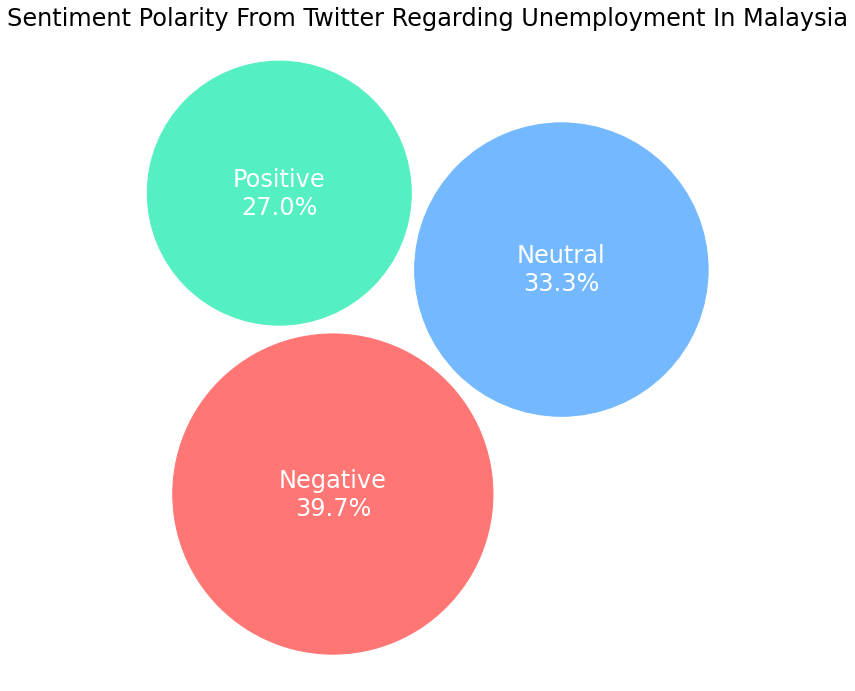

In [108]:
bubble_chart = BubbleChart(area=df_bubble["percentage"],bubble_spacing=0.3)
bubble_chart.collapse()

fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"), figsize=(12, 12))
bubble_chart.plot(ax, df_bubble["text"], df_bubble["color"])

ax.axis("off")
ax.relim()
ax.autoscale_view()
ax.set_title('Sentiment Polarity From Twitter Regarding Unemployment In Malaysia', fontsize=24)

plt.savefig("../visualizations/unemployment-bubble.png")
plt.show()